In [3]:
# ! wget https://www.dropbox.com/s/m7n1921svqig6ev/mnist32.tar.bz2?dl=0 -O mnist32.tar.bz2
# ! tar -jxvf mnist32.tar.bz2

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
NUM_CLASS = 10
IMG_SIZE = (32,32)
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 265
EPOCHS = 50

In [6]:
# train_dir = '/home/a/datasets/mnist32/training'
# test_dir = '/home/a/datasets/mnist32/testing'

train_dir = 'mnist32/training'
test_dir = 'mnist32/testing'

In [7]:
resnet = keras.applications.ResNet50V2(include_top=False,
                                       weights=None,
                                       input_shape=IMG_SHAPE,
                                       pooling='avg')

In [8]:
inputs = keras.Input(shape=IMG_SHAPE)
outputs = resnet(inputs)
encoder = keras.Model(inputs, outputs, name='my-encoder')

In [9]:
encoder.summary()

Model: "my-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
Total params: 23,564,800
Trainable params: 23,519,360
Non-trainable params: 45,440
_________________________________________________________________


In [10]:
features = encoder(inputs)   # todo: single model encoder + classifier
features = layers.Dropout(0.5)(features)
features = layers.Dense(512, activation='relu')(features)  # todo: try on mnist_cnn
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation='softmax')(features)
model = keras.Model(inputs, outputs, name='my-classifier' )

In [11]:
# model.compile(optimizer='adam', 
#               loss=keras.losses.SparseCategoricalCrossentropy(),
#               metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# model.loss.get_config()

In [14]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [15]:
model.summary()

Model: "my-classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
my-encoder (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 24,619,018
Trainable params: 24,573,578
Non-trainable params: 45,440
____________________________________

In [16]:
train_gen = ImageDataGenerator(rotation_range=15,
                               width_shift_range=0.2,
                               height_shift_range=0.1,
                               zoom_range=0.1)

In [17]:
training_set = train_gen.flow_from_directory(train_dir,
                                             target_size=IMG_SIZE,
                                             batch_size=BATCH_SIZE,
                                             color_mode='rgb')

test_set = train_gen.flow_from_directory(test_dir,
                                         target_size=IMG_SIZE,
                                         batch_size=BATCH_SIZE,
                                         color_mode='rgb')

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [18]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # better than val_acc
                                               patience=5, 
                                               mode='auto', # default
                                               verbose=1)

In [19]:
training_set

In [20]:
history = model.fit(training_set,
                    validation_data=test_set,
                    epochs=EPOCHS,
                    callbacks=[es_callback])

Epoch 1/50
227/227 [==============================] - 89s 330ms/step - loss: 1.1491 - accuracy: 0.6380 - val_loss: 0.2806 - val_accuracy: 0.9153
Epoch 2/50
227/227 [==============================] - 72s 319ms/step - loss: 0.1571 - accuracy: 0.9557 - val_loss: 0.1992 - val_accuracy: 0.9484
Epoch 3/50
227/227 [==============================] - 72s 317ms/step - loss: 0.1065 - accuracy: 0.9710 - val_loss: 0.1215 - val_accuracy: 0.9655
Epoch 4/50
227/227 [==============================] - 72s 318ms/step - loss: 0.0844 - accuracy: 0.9768 - val_loss: 0.1065 - val_accuracy: 0.9754
Epoch 5/50
227/227 [==============================] - 72s 315ms/step - loss: 0.0776 - accuracy: 0.9788 - val_loss: 0.0795 - val_accuracy: 0.9770
Epoch 6/50
227/227 [==============================] - 72s 318ms/step - loss: 0.0714 - accuracy: 0.9797 - val_loss: 0.0782 - val_accuracy: 0.9771
Epoch 7/50
227/227 [==============================] - 72s 318ms/step - loss: 0.0588 - accuracy: 0.9828 - val_loss: 0.0574 - val_ac

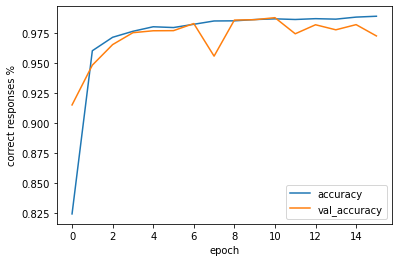

In [21]:
plt.plot(history.history['accuracy'],
         label='accuracy')
plt.plot(history.history['val_accuracy'],
         label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('correct responses %')
plt.legend()
plt.show()

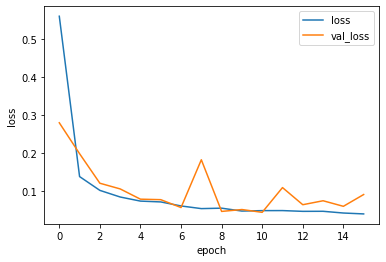

In [22]:
plt.plot(history.history['loss'],
         label='loss')
plt.plot(history.history['val_loss'],
         label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:
model.save('es_cl_fold_k.h5')